In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [7]:
#PyTorch
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
# Prepare paths of input images and target segmentation masks
left_input_dir = "./output_images/output/left/"
right_input_dir = "./output_images/output/right/"
depth_dir = "./output_images/depth"

img_size = (320, 320)          #This is the biggest image I could get
num_classes = 4
batch_size = 16                # Bigger sizes sometimes couse crashes due to low memory
lower_color_threshold = 100


# Sorting image names in left input folder
left_input_img_paths = sorted([
    os.path.join(left_input_dir, fname)
    for fname in os.listdir(left_input_dir)
    if fname.endswith(".jpg")
])

# Sorting image names in left input folder
right_input_img_paths = sorted([
    os.path.join(right_input_dir, fname)
    for fname in os.listdir(right_input_dir)
    if fname.endswith(".jpg")
])

# Sorting image names in target folder
target_img_paths = sorted([
    os.path.join(depth_dir, fname)
    for fname in os.listdir(depth_dir)
    if fname.endswith(".jpg")
])

print("Number of left input samples:", len(left_input_img_paths))
print("Number of right input samples:", len(right_input_img_paths))
print("Number of target samples:", len(target_img_paths))

#Input and target images are now corresponding
for input_path, target_path in zip(left_input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of left input samples: 1119
Number of right input samples: 1119
Number of target samples: 1120
./output_images/output/left/image_depth_1701624237_257517568.jpg | ./output_images/depth/image_depth_1701624237_257517568.jpg
./output_images/output/left/image_depth_1701624238_197022720.jpg | ./output_images/depth/image_depth_1701624238_197022720.jpg
./output_images/output/left/image_depth_1701624238_857298688.jpg | ./output_images/depth/image_depth_1701624238_857298688.jpg
./output_images/output/left/image_depth_1701624239_787462144.jpg | ./output_images/depth/image_depth_1701624239_787462144.jpg
./output_images/output/left/image_depth_1701624240_603289856.jpg | ./output_images/depth/image_depth_1701624240_603289856.jpg
./output_images/output/left/image_depth_1701624241_240535808.jpg | ./output_images/depth/image_depth_1701624241_240535808.jpg
./output_images/output/left/image_depth_1701624241_954830080.jpg | ./output_images/depth/image_depth_1701624241_954830080.jpg
./output_images/

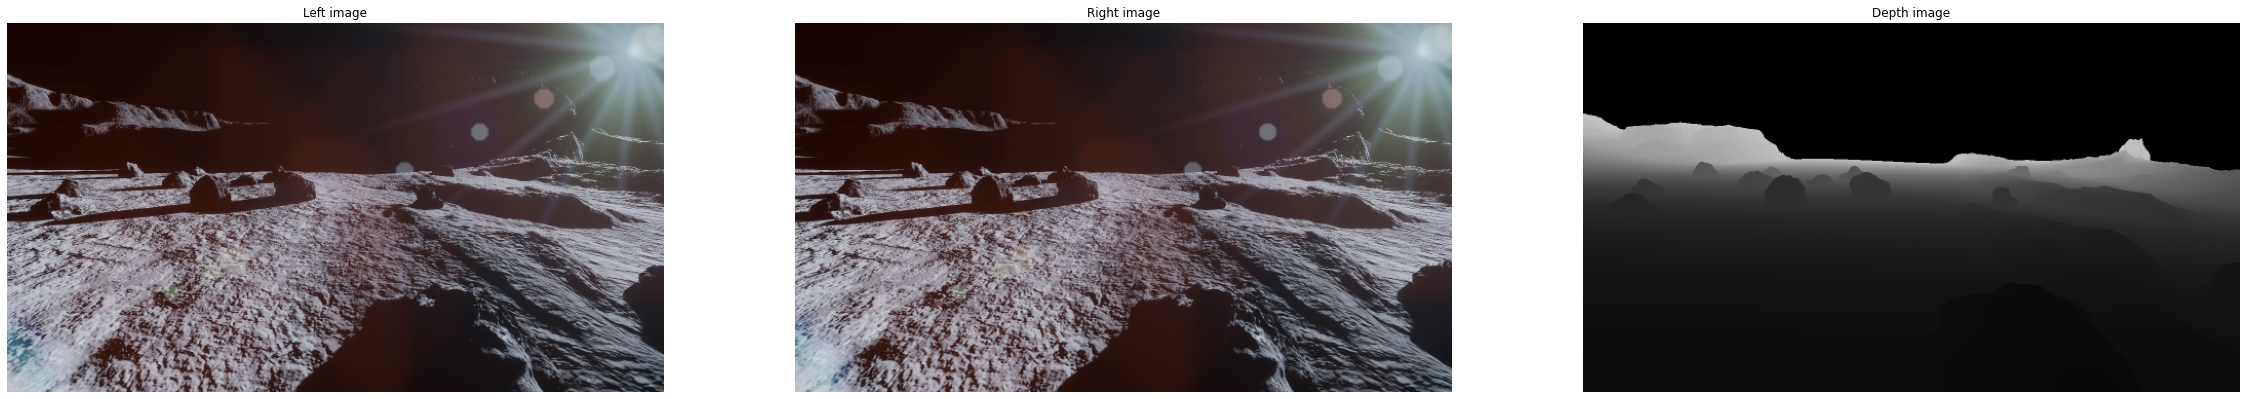

In [9]:
def load_image(path, size):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

fig, axes = plt.subplots(1, 3, figsize=(40, 20))

index = 100
size= (640, 360)

# Assuming there are exactly three images
axes[0].imshow(load_image(left_input_img_paths[index], size))
axes[0].set_title("Left image")
axes[0].axis('off')

axes[1].imshow(load_image(right_input_img_paths[index], size))
axes[1].set_title("Right image")
axes[1].axis('off')

axes[2].imshow(load_image(target_img_paths[index], size))
axes[2].set_title("Depth image")
axes[2].axis('off')

plt.show()

In [15]:
class LunarStereoData(Dataset):
    
    def __init__(self, input_left_paths, input_right_paths, target_paths, img_size):
        self.left_img_paths = input_left_paths
        self.right_img_paths = input_right_paths
        self.target_paths = target_paths
        self.img_size = img_size

    def read_img(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        return img
        
    def __getitem__(self, idx):

        left_img = self.read_img(self.left_img_paths[idx])
        right_img = self.read_img(self.right_img_paths[idx])
        target = self.read_img(self.target_paths[idx])

        input_imgs = (left_img, right_img)
        
        return (input_imgs, target)
        
    def __len__ (self):
        return len(self.target_size)

In [18]:
loader = LunarStereoData(left_input_img_paths, right_input_img_paths, target_img_paths, size)
test_data = loader.__getitem__(1)
print(test_data)

((array([[[ 28,  26,  29],
        [ 28,  26,  31],
        [ 28,  26,  31],
        ...,
        [  9,  12,  17],
        [  9,  12,  17],
        [  9,  12,  17]],

       [[ 28,  26,  29],
        [ 28,  26,  31],
        [ 28,  26,  31],
        ...,
        [  9,  12,  17],
        [  9,  12,  17],
        [  9,  12,  17]],

       [[ 28,  26,  29],
        [ 28,  26,  31],
        [ 28,  26,  31],
        ...,
        [  9,  12,  17],
        [  9,  12,  17],
        [  9,  12,  17]],

       ...,

       [[ 23,  30,  38],
        [ 58,  65,  73],
        [ 98, 107, 116],
        ...,
        [ 39,  27,  29],
        [ 30,  16,  16],
        [ 31,  16,  13]],

       [[ 75,  82,  90],
        [120, 127, 135],
        [128, 137, 146],
        ...,
        [ 29,  15,  15],
        [ 32,  16,  16],
        [ 30,  15,  12]],

       [[127, 134, 142],
        [125, 134, 143],
        [127, 136, 145],
        ...,
        [ 31,  15,  15],
        [ 29,  13,  13],
        [ 31,  15,  15

In [22]:
# Models from https://github.com/cogsys-tuebingen/mobilestereonet
from models import __models__, model_loss
modelName = '2D-MobileStereoNet'

model = __models__['MSNet2D'](192)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
def train():
    best_checkpoint_loss = 100
    for epoch_idx in range(start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch_idx, args.lr, args.lrepochs)

        # training
        for batch_idx, sample in enumerate(TrainImgLoader):
            global_step = len(TrainImgLoader) * epoch_idx + batch_idx
            start_time = time.time()
            do_summary = global_step % args.summary_freq == 0
            loss, scalar_outputs, image_outputs = train_sample(sample, compute_metrics=do_summary)
            if do_summary:
                save_scalars(logger, 'train', scalar_outputs, global_step)
                save_images(logger, 'train', image_outputs, global_step)
            del scalar_outputs, image_outputs
            print('Epoch {}/{}, Iter {}/{}, train loss = {:.3f}, time = {:.3f}'.format(epoch_idx, args.epochs,
                                                                                       batch_idx,
                                                                                       len(TrainImgLoader), loss,
                                                                                       time.time() - start_time))
        # saving checkpoints
        if (epoch_idx + 1) % args.save_freq == 0:
            checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint_data, "{}/checkpoint_{:0>6}.ckpt".format(args.logdir, epoch_idx))
        gc.collect()

        # testing
        avg_test_scalars = AverageMeterDict()
        for batch_idx, sample in enumerate(TestImgLoader):
            global_step = len(TestImgLoader) * epoch_idx + batch_idx
            start_time = time.time()
            do_summary = global_step % args.summary_freq == 0
            loss, scalar_outputs, image_outputs = test_sample(sample, compute_metrics=do_summary)
            if do_summary:
                save_scalars(logger, 'test', scalar_outputs, global_step)
                save_images(logger, 'test', image_outputs, global_step)
            avg_test_scalars.update(scalar_outputs)
            del scalar_outputs, image_outputs
            print('Epoch {}/{}, Iter {}/{}, test loss = {:.3f}, time = {:3f}'.format(epoch_idx, args.epochs,
                                                                                     batch_idx,
                                                                                     len(TestImgLoader), loss,
                                                                                     time.time() - start_time))
        avg_test_scalars = avg_test_scalars.mean()

        save_scalars(logger, 'fulltest', avg_test_scalars, len(TrainImgLoader) * (epoch_idx + 1))
        print("avg_test_scalars", avg_test_scalars)

        # saving new best checkpoint
        if avg_test_scalars['loss'] < best_checkpoint_loss:
            best_checkpoint_loss = avg_test_scalars['loss']
            print("Overwriting best checkpoint")
            checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint_data, "{}/best.ckpt".format(args.logdir))

        gc.collect()

